<table style="width:100%; border:none;">
  <tr>
    <td style="width:150px; text-align:center; vertical-align:middle;">
      <img src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" 
           alt="Emblema UPO" 
           style="width:130px; margin:10px;">
    </td>
    <td style="text-align:center; vertical-align:middle;">
      <h2 style="margin-bottom:5px;">Universidad Pablo de Olavide</h2>
      <p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p>
      <p><strong>Asignatura: Inteligencia Artificial</strong></p>
      <p><strong>Curso 2025/2026</strong></p>
      <h3 style="margin-top:10px;">TRABAJO #1 – Equipo 08</h3>
      <h4 style="margin-top:5px;">Dataset asignado: Nº 17</h4>
      <p><strong>Integrantes:</strong> María Pérula Gutiérrez &nbsp;·&nbsp; Jonathan Javier Quishpe Maldonado</p>
      <p><strong>Fecha de entrega:</strong> 01/12/2025</p>
    </td>
  </tr>
</table>

<hr style="margin-top:25px; margin-bottom:25px; border: 1px solid #bbb;">
<h2 style="text-align:center;">Regresión Logística - Implementación</h2>

In [2]:
# REGRESIÓN LOGÍSTICA => Coche para estudiante

# Aquí usaremos la regresión logística para separar los coches de nuestro dataset en dos grupos:
#   1 -> coche recomendable para un estudiante universitario
#   0 -> coche que no lo es
#
# Para decidir qué coche es bueno para estudiante nos hemos guiado por caracteristicas de un alumno medio de universidad:
#   - que no sea muy caro,
#   - que gaste poco (economy alta),
#   - que no esté en muy mal estado para no tener muchas averias (condition decente)
#
# Por lo que definiremos una variable binaria (estudiante_ok), y como variables de entrada: price, km, economy, condition y rating. A partir de ahí aplicaremos exactamente
# el esquema de regresión logística de la EPD 3

### 1. Importaciones y lectura del dataset

In [3]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("train.csv")
df = df.rename(columns={"current price": "price"})

In [5]:
#Creamos la variable binaria de estudiante_ok
precio_medio = df["price"].mean()

df["estudiante_ok"] = ((df["economy"] >= 8) & (df["condition"] >= 3) & (df["price"] <= precio_medio)).astype(int)

print("Primeras filas + estudiante_ok:\n")
print(df[["price", "km", "economy", "condition", "rating", "estudiante_ok"]].head())

Primeras filas + estudiante_ok:

      price      km  economy  condition  rating  estudiante_ok
0  351318.0   78945       14          2       1              0
1  285001.5  117220        9          9       5              1
2  215386.0  132538       15          8       2              1
3  244295.5  101065       11          3       4              1
4  531114.5   61559       12          9       3              0


### 2. Variables de entrada X y la clase y | Normalización de características

In [6]:
columnas_X = ["price", "km", "economy", "condition", "rating"]
#X = df[columnas_X].copy()
X_full = df[columnas_X].copy()
y_full = df[["estudiante_ok"]].copy()

#Normalizamos porque nos sale "overflow encountered in exp" en punto "6. Theta, coste y gradiente iniciales"
def featureNormalize(X):
    media = X.mean()
    desv = X.std()
    X_norm = (X - media) / desv
    return X_norm, media, desv

X_norm, media_log, desv_log = featureNormalize(X_full)

unos = np.ones(len(X_norm))
X = X_norm.copy()
X.insert(0, "ones", unos)

print("\nShape de X:", X.shape)
print("Shape de y:", y_full.shape)


Shape de X: (1000, 6)
Shape de y: (1000, 1)


### 3. Función sigmoide

In [7]:
def sigmoid(z):
    # Clipear z para evitar overflow en exp(-z)
    # Cuando z es muy grande (>500), exp(-z) -> 0, entonces sigmoid -> 1
    # Cuando z es muy pequeño (<-500), exp(-z) -> infinito, entonces sigmoid -> 0
    z = np.clip(z, -500, 500)
    denominador = 1 + np.exp(-z)
    g = 1 / denominador
    return g

### 4. Función coste (vectorizada)

In [8]:
def costFunction(theta, X, y):
    m = len(y)
    Xn = X.values # m,n
    yn = y # yn vector de 1D
    z = Xn.dot(theta) # m
    
    h = sigmoid(z) #m
   #Evitamos el log(0) ya que nha encontrado valores 0 o 1 en "6. Theta, coste y gradiente iniciales"
    eps = 1e-8
    h = np.clip(h, eps, 1 - eps)
    
    termino1 = yn * np.log(h)
    termino2 = (1 - yn) * np.log(1 - h)

    J = (-1/m) * np.sum(termino1 + termino2)
    return J

### 5. Función gradiente (vectorizada)

In [9]:
def gradientFunction(theta, X, y_vec):
    m = len(y_vec)
    Xn = X.values
    z = Xn.dot(theta)
    h = sigmoid(z)
    grad = (1/m) * (Xn.T.dot(h - y_vec)) # n
    return grad

### 6. Función predicción

In [10]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

### 7. Validación cruzada - 10 repeticiones (90%/10%)

In [11]:

np.random.seed(0) #mismos splits

alpha = 0.01 #fmin_cg hace su propio paso, este alpha no se usa aqui
maxiter = 400 #nmax iteraciones fmin_cg
n_reps = 10 #10 particiones

accuracy_list = []
TP_list, TN_list, FP_list, FN_list = [], [], [], []

theta_opt_main = None
media_main = None
desv_main = None
cost_history_main = None

for rep in range(n_reps):
    m = len(X_full)
    idx = np.random.permutation(m)
    train_size = int(0.9 * m)

    #90% train, 10% test -> recomendado por la profesora porque no tenemos muchisimos datos
    idx_train = idx[:train_size]
    idx_test  = idx[train_size:]

    X_train_raw = X_full.iloc[idx_train].copy()
    y_train = y_full.iloc[idx_train].copy() #(m_train,1)

    X_test_raw = X_full.iloc[idx_test].copy()
    y_test = y_full.iloc[idx_test].copy()

    #Normalizamos SOLO estadisticas train
    X_train_norm, media, desv = featureNormalize(X_train_raw)
    X_test_norm = (X_test_raw - media) / desv

    #print("DEBUG: tamaño de X_train:", X_train_norm.shape)

    #Añadimos columna de unos
    X_train_norm.insert(0, "ones", 1)
    X_test_norm.insert(0, "ones", 1)

    # heta inicial a ceros (igual que en EPD)
    theta_ini = np.zeros(X_train_norm.shape[1])
    y_train_vec = y_train.to_numpy().flatten()

    #print(theta_ini)

    #Guardar historia de coste solo para esta rep.
    cost_history_rep = []
    def guardar_coste_log(theta_actual):
        c = costFunction(theta_actual, X_train_norm, y_train_vec)
        cost_history_rep.append(c)

    #Entrenamos solo con conjunto de entrenamiento
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_train_norm, y_train_vec),
        maxiter=maxiter,
        callback=guardar_coste_log,
        disp=False # para que no saque todo el log en cada rep.
    )

    #print(theta_opt)

    #Guardamos PRIMERA repetición para dibujar la gráfica y usar como modelo
    if rep == 0:
        theta_opt_main = theta_opt
        media_main = media
        desv_main = desv
        cost_history_main = cost_history_rep

    #Prediccion en el conjunto de test
    y_pred_test = predict(theta_opt, X_test_norm, bool_round=True).astype(int)
    y_test_vec = y_test.to_numpy().flatten()

    #Métricas en test
    accuracy = np.mean(y_pred_test == y_test_vec)
    TP = np.sum((y_test_vec == 1) & (y_pred_test == 1))
    TN = np.sum((y_test_vec == 0) & (y_pred_test == 0))
    FP = np.sum((y_test_vec == 0) & (y_pred_test == 1))
    FN = np.sum((y_test_vec == 1) & (y_pred_test == 0))

    accuracy_list.append(accuracy)
    TP_list.append(TP); TN_list.append(TN); FP_list.append(FP); FN_list.append(FN)

    print(f"Repetición {rep+1} / Accuracy test = {accuracy:.3f}  (TP={TP}, TN={TN}, FP={FP}, FN={FN})")

print("\nMEDIA de las 10 repeticiones (TEST):")
print("Accuracy medio :", np.mean(accuracy_list))
print("TP medio       :", np.mean(TP_list))
print("TN medio       :", np.mean(TN_list))
print("FP medio       :", np.mean(FP_list))
print("FN medio       :", np.mean(FN_list))

#Trabajamos con modelo de la primera repetición (gráficas, ejemplo...)
theta_opt = theta_opt_main
media_log = media_main
desv_log = desv_main
cost_history_log = cost_history_main

Repetición 1 / Accuracy test = 0.850  (TP=28, TN=57, FP=8, FN=7)
Repetición 2 / Accuracy test = 0.890  (TP=27, TN=62, FP=2, FN=9)
Repetición 3 / Accuracy test = 0.870  (TP=27, TN=60, FP=7, FN=6)
Repetición 4 / Accuracy test = 0.880  (TP=32, TN=56, FP=8, FN=4)
Repetición 5 / Accuracy test = 0.840  (TP=37, TN=47, FP=8, FN=8)
Repetición 6 / Accuracy test = 0.860  (TP=30, TN=56, FP=5, FN=9)
Repetición 7 / Accuracy test = 0.850  (TP=35, TN=50, FP=6, FN=9)
Repetición 8 / Accuracy test = 0.850  (TP=28, TN=57, FP=6, FN=9)
Repetición 9 / Accuracy test = 0.870  (TP=33, TN=54, FP=7, FN=6)
Repetición 10 / Accuracy test = 0.850  (TP=28, TN=57, FP=4, FN=11)

MEDIA de las 10 repeticiones (TEST):
Accuracy medio : 0.8610000000000001
TP medio       : 30.5
TN medio       : 55.6
FP medio       : 6.1
FN medio       : 7.8


### 8. Theta, coste y gradiente iniciales

In [12]:
n_param = X.shape[1]
theta_ini = np.zeros(n_param) #vector 1D
y_vec = y_full.to_numpy().flatten() #m

print("\nCoste inicial con theta (0): ", costFunction(theta_ini, X, y_vec))
print("Gradiente inicial: \n", gradientFunction(theta_ini, X, y_vec))

#Para la gráfica
cost_history_log = []
def guardar_coste_log(theta):
    c = costFunction(theta, X, y_vec)
    cost_history_log.append(c)

# Optimizacion fmin_cg
theta_opt = op.fmin_cg(
    f = costFunction,
    x0 = theta_ini,
    fprime = gradientFunction,
    args = (X, y_vec),
    maxiter = 400,
    callback = guardar_coste_log
)

print("\nTheta optimo:")
print(theta_opt)


Coste inicial con theta (0):  0.6931471805599454
Gradiente inicial: 
 [ 0.092       0.3397436  -0.33782546 -0.01927776 -0.09611219  0.0307273 ]
Optimization terminated successfully.
         Current function value: 0.289499
         Iterations: 20
         Function evaluations: 63
         Gradient evaluations: 63

Theta optimo:
[-1.04196569 -3.10130639  0.22287656  0.03599764  1.41479513 -0.19275264]


### 9. Gráfica de convergencia

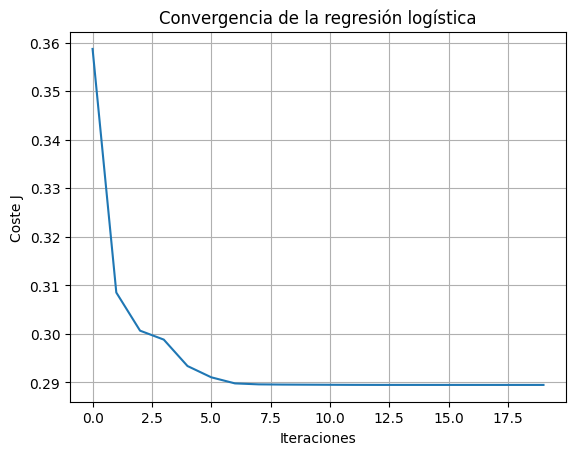

In [13]:
plt.plot(cost_history_log)
plt.xlabel("Iteraciones")
plt.ylabel("Coste J")
plt.title("Convergencia de la regresión logística")
plt.grid(True)
plt.show()

### 10. Predicciones

In [14]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

# Necesitamos: Coche barato, con pocos km, que tenga buena economía con una condición decente y un rating medio aceptable
# Valores seleccionados [price, km, economy, condition, rating]
ejemplo_coche_raw = [200000, 50000, 9, 4, 4]

# Normalizamos usando media/desviación qdel entrenamiento
ejemplo_norm = (np.array(ejemplo_coche_raw) - media_log.values) / desv_log.values

# Añadimos el 1 inicial
fila_ejemplo = np.insert(ejemplo_norm, 0, 1)  # [1, price, km, economy, condition, rating]

df_ejemplo = pd.DataFrame([fila_ejemplo], columns=X.columns)

ej_prob = predict(theta_opt, df_ejemplo, bool_round=False)
ej_clase = predict(theta_opt, df_ejemplo, bool_round=True)

print("\nEjemplo de coche para estudiante:")
print("Características originales (sin normalizar):", ejemplo_coche_raw)
print("Probabilidad de ser 'estudiante_ok':", float(ej_prob[0]))
print("Predicción (0/1):", int(ej_clase[0]))


Ejemplo de coche para estudiante:
Características originales (sin normalizar): [200000, 50000, 9, 4, 4]
Probabilidad de ser 'estudiante_ok': 0.5459667519044216
Predicción (0/1): 1


### 11. Evaluación usando TODO el dataset

In [15]:
X_full_norm = (X_full - media_log) / desv_log
X_full_norm.insert(0, "ones", 1)

y_pred_full = predict(theta_opt, X_full_norm, bool_round=True).astype(int)
y_real_full = y_full.to_numpy().flatten()

accuracy_full = np.mean(y_pred_full == y_real_full)
print("\nAccuracy del modelo sobre TODO el dataset:", accuracy_full)

TP = np.sum((y_real_full == 1) & (y_pred_full == 1))
TN = np.sum((y_real_full == 0) & (y_pred_full == 0))
FP = np.sum((y_real_full == 0) & (y_pred_full == 1))
FN = np.sum((y_real_full == 1) & (y_pred_full == 0))

print("\nMatriz de confusión (todo el dataset):")
print("TP (1 bien predicho):", TP)
print("TN (0 bien predicho):", TN)
print("FP (0 mal como 1)   :", FP)
print("FN (1 mal como 0)   :", FN)


Accuracy del modelo sobre TODO el dataset: 0.856

Matriz de confusión (todo el dataset):
TP (1 bien predicho): 329
TN (0 bien predicho): 527
FP (0 mal como 1)   : 65
FN (1 mal como 0)   : 79


In [16]:
# Conclusiones: El modelo de regresión logística para estudiante_ok da un accuracy de 0.85 (85%), acierta aproximadamente 8 de cada 10 coches, que está bastante bien
# para las 5 variables que usamos.
#
# La matriz de confusión muestra que acierta bastantes ok y no ok, aunque hay algunos coches buenos que descarta y otros que sobrevalora, algo típico en este modelo sencillo.
#
# Viendo las gráficas de price vs economy, tanto los datos reales como las predicciones siguen la idea que teníamos: los coches más baratos y con mejor
# economía son los que salen como buenos para un estudiante.

### 12. Gráfica price vs economy (real vs predicho)

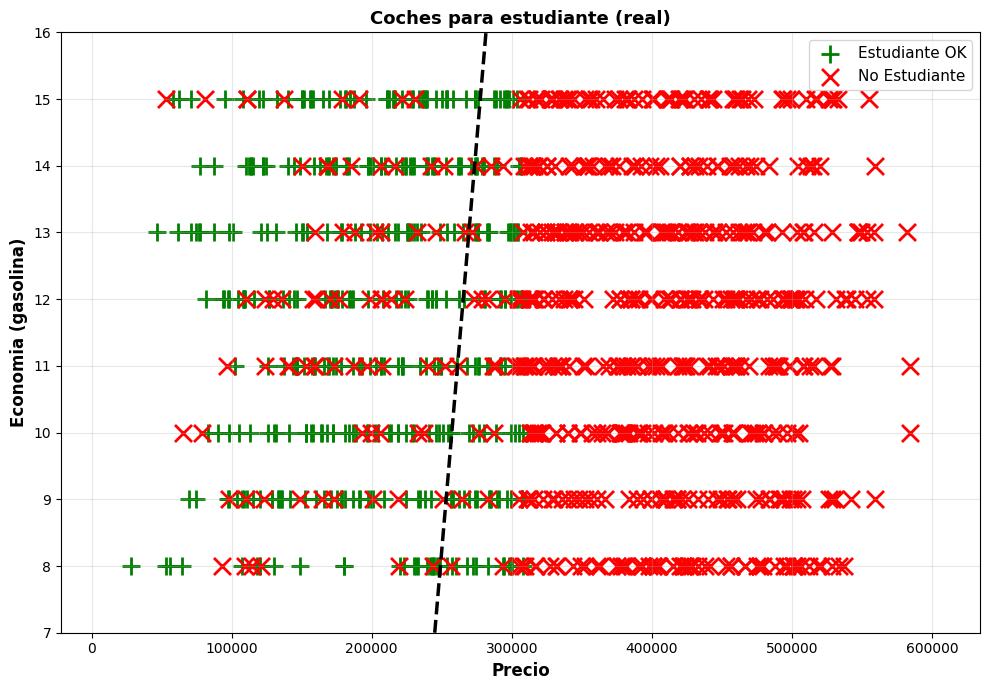

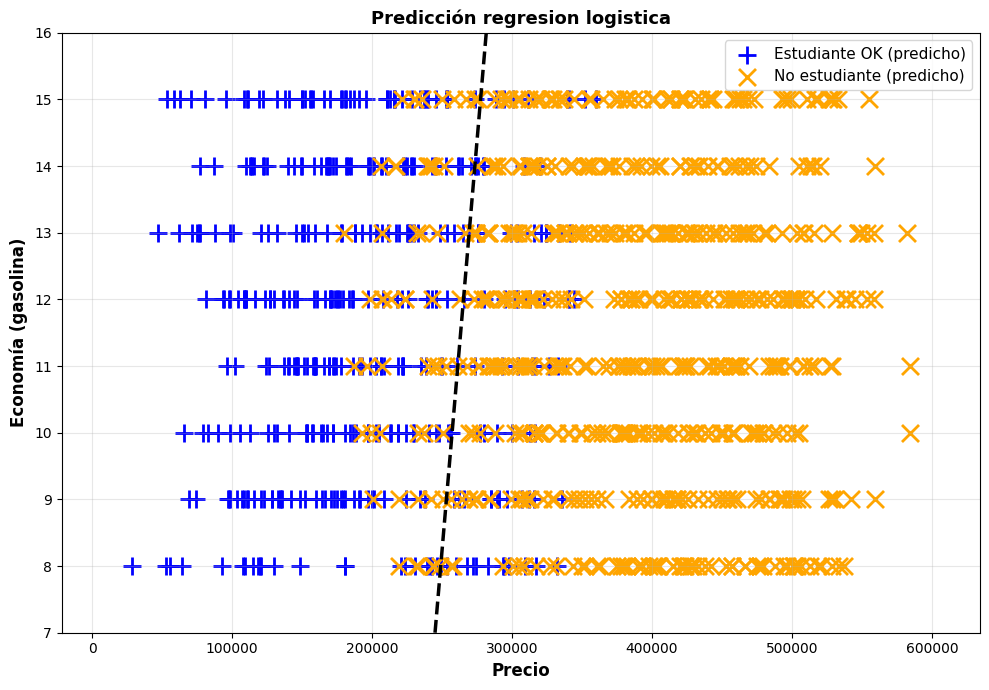

In [17]:
# En nuestro caso estamos usando 5 variables para saber si un coche es apropiado para un estudiante medio, pero como no se puede dibujar en 5D,
# hemos pensado en observar estas gráficas con dos variables bastante significativas en este caso: price y economy.
# Un estudiante principalmente (según nuestro criterio), se fija en estas dos opciones.

import matplotlib.pyplot as plt

# Dibujamos los puntos reales segun la clase
def plot_estudiante_real(df):
    
    df_ok = df[df["estudiante_ok"] == 1]
    df_no = df[df["estudiante_ok"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df["price"].min() - 50000, df["price"].max() + 50000
    min_econ, max_econ = df["economy"].min() - 1, df["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="g", marker="+", s=150, label="Estudiante OK", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="r", marker="x", s=150, label="No Estudiante", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economia (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Coches para estudiante (real)", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Dibujamos lo que predice nuestra regresion logistica
def plot_estudiante_pred(df_clasif):
    
    df_ok = df_clasif[df_clasif["pred_clase"] == 1]
    df_no = df_clasif[df_clasif["pred_clase"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df_clasif["price"].min() - 50000, df_clasif["price"].max() + 50000
    min_econ, max_econ = df_clasif["economy"].min() - 1, df_clasif["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla (VERSIÓN VECTORIZADA - OPTIMIZADA)
    # En lugar de usar bucles anidados, vectorizamos toda la operación
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))

    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="b", marker="+", s=150, label="Estudiante OK (predicho)", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="orange", marker="x", s=150, label="No estudiante (predicho)", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economía (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Predicción regresion logistica", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Clasificamos el dataset con el modelo aprendido
pred_clase = predict(theta_opt, X, bool_round=True)

df_clasificado = df.copy()
df_clasificado["pred_clase"] = pred_clase

# Gráfica del real
plot_estudiante_real(df)

# Gráfica del predicho
df_clasificado_plot = df_clasificado.copy()
df_clasificado_plot["price"] = df["price"]
df_clasificado_plot["economy"] = df["economy"]

plot_estudiante_pred(df_clasificado_plot)

# Conclusión: En la gráfica real los coches marcados como estudiante_ok están sobre todo en la zona de precio bajo y economía baja.
# En la grafica de predicción se ve un patrón parecido: el modelo tiende a marcar como buenos para estudiante los coches más baratos, aunque hay algunos puntos que se escapan en la economía (gasto medio gasolina)
# Para ser un modelo sencillo con 5 variables, la tasa de acierto es razonable (85%).

### 13. Análisis de la Tasa de Aprendizaje (Alpha)

#### 13.1 Introducción Teórica

La **tasa de aprendizaje (alpha)** es uno de los hiperparámetros más críticos en el algoritmo de **descenso de gradiente**. Este parámetro controla el tamaño de los pasos que tomamos hacia el mínimo de la función de coste durante la optimización.

**¿Qué es Alpha?**

En cada iteración del descenso de gradiente, actualizamos los parámetros theta según:

$$\theta := \theta - \alpha \cdot \nabla J(\theta)$$

Donde:
- $\alpha$ es la **tasa de aprendizaje** (alpha)
- $\nabla J(\theta)$ es el **gradiente** de la función de coste
- El producto $\alpha \cdot \nabla J(\theta)$ determina el **tamaño del paso**


**Importancia de la Normalización:**

La normalización de características es fundamental porque:
- Sin normalización, las características tienen **escalas muy diferentes**
- Esto hace que los gradientes sean desproporcionales
- Un alpha que funciona para una característica puede causar divergencia en otra
- **Con normalización**, todas las características están en escala similar (media 0, desviación 1)
- Esto permite usar values de alpha mayores de forma segura

#### 13.2 Experimentación

En esta sección evaluaremos cómo se comporta el descenso de gradiente para diferentes valores de alpha: **0.001, 0.01, 0.1, 1, 10 y 100**, ejecutando **50 y 400 iteraciones** con nuestro dataset de coches normalizado y posteriormente sin normalizar para estudiar su comportamiento.

Analizaremos especialmente:
- La **curva de convergencia** para cada alpha
- Qué alphas convergen y cuáles divergen
- Cómo varía la velocidad de convergencia con alpha
- El efecto de la **normalización** comparando resultados con y sin ella


In [24]:

def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Realiza el descenso de gradiente para aprender theta.
    Actualiza theta tomando num_iters pasos de gradiente con una tasa de aprendizaje alpha.
    """
    m = len(y)
    J_history = []
    
    for i in range(num_iters):
        grad = gradientFunction(theta, X, y)
        theta = theta - alpha * grad
        cost = costFunction(theta, X, y)
        J_history.append(cost)
        
    return theta, J_history


# ================================================================================
# RESUMEN CUANTITATIVO: ANÁLISIS DE CONVERGENCIA PARA CADA ALPHA
# ================================================================================
print("\n" + "="*80)
print("RESUMEN CUANTITATIVO: ANÁLISIS DE CONVERGENCIA PARA CADA ALPHA")
print("="*80)

alphas_test = [0.001, 0.01, 0.1, 1, 10, 100]
num_iters_test = 400

print(f"\nAnálisis con {num_iters_test} iteraciones y datos NORMALIZADOS:\n")
print(f"{'Alpha':<10} {'Coste Inicial':<20} {'Coste Final':<20} {'Cambio (%)':<15} {'Accuracy':<12} {'Estado':<15}")
print("-" * 100)

for alpha in alphas_test:
    theta_ini = np.zeros(X.shape[1])
    theta_opt, J_history = gradientDescent(X, y_vec, theta_ini, alpha, num_iters_test)
    
    coste_inicial = J_history[0]
    coste_final = J_history[-1]
    cambio_porcentaje = ((coste_final - coste_inicial) / coste_inicial) * 100
    
    # Calcular accuracy en el dataset completo
    y_pred = sigmoid(X.values @ theta_opt) >= 0.5
    accuracy = np.mean(y_pred == y_vec)
    
    # Determinar estado: convergencia o divergencia
    # Consideramos divergencia si hay oscilaciones significativas o si el coste sube mucho en el camino
    coste_max = max(J_history)
    coste_min = min(J_history)
    rango_oscilacion = coste_max - coste_min
    
    if cambio_porcentaje < 0 and rango_oscilacion < 0.5:  # Convergencia suave
        estado = "CONVERGENCIA"
    else:
        estado = "DIVERGENCIA"
    
    print(f"{alpha:<10} {coste_inicial:<20.6e} {coste_final:<20.6e} {cambio_porcentaje:>13.2f}% {accuracy:>10.4f} {estado:<15}")

print("\n" + "="*80 + "\n")




RESUMEN CUANTITATIVO: ANÁLISIS DE CONVERGENCIA PARA CADA ALPHA

Análisis con 400 iteraciones y datos NORMALIZADOS:

Alpha      Coste Inicial        Coste Final          Cambio (%)      Accuracy     Estado         
----------------------------------------------------------------------------------------------------
0.001      6.928987e-01         6.098316e-01                -11.99%     0.8750 CONVERGENCIA   
0.01       6.906672e-01         3.886075e-01                -43.73%     0.8700 CONVERGENCIA   
0.1        6.688619e-01         2.996628e-01                -55.20%     0.8460 CONVERGENCIA   
1          4.998239e-01         2.896737e-01                -42.04%     0.8530 CONVERGENCIA   
10         4.866916e-01         2.894989e-01                -40.52%     0.8530 CONVERGENCIA   
100        1.717404e+00         1.196179e+00                -30.35%     0.8760 DIVERGENCIA    




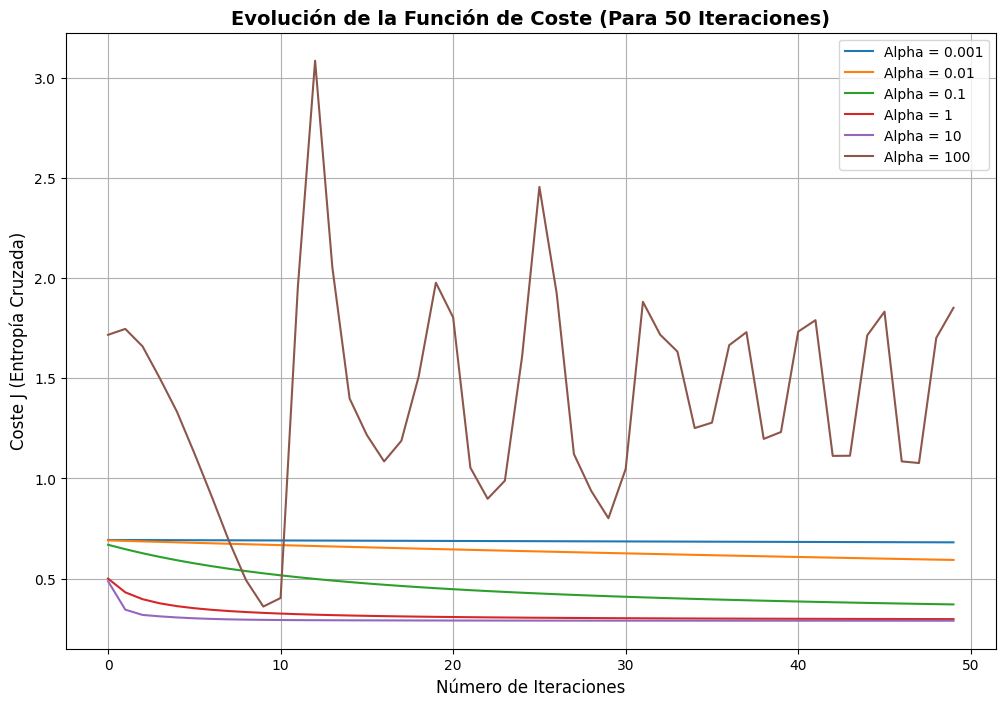

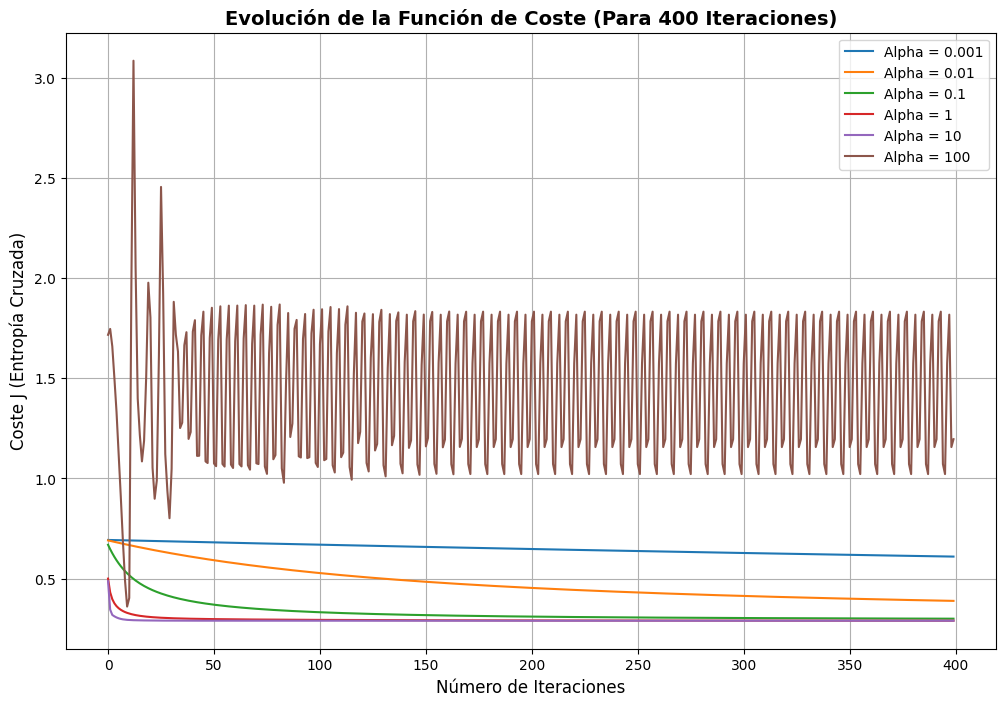

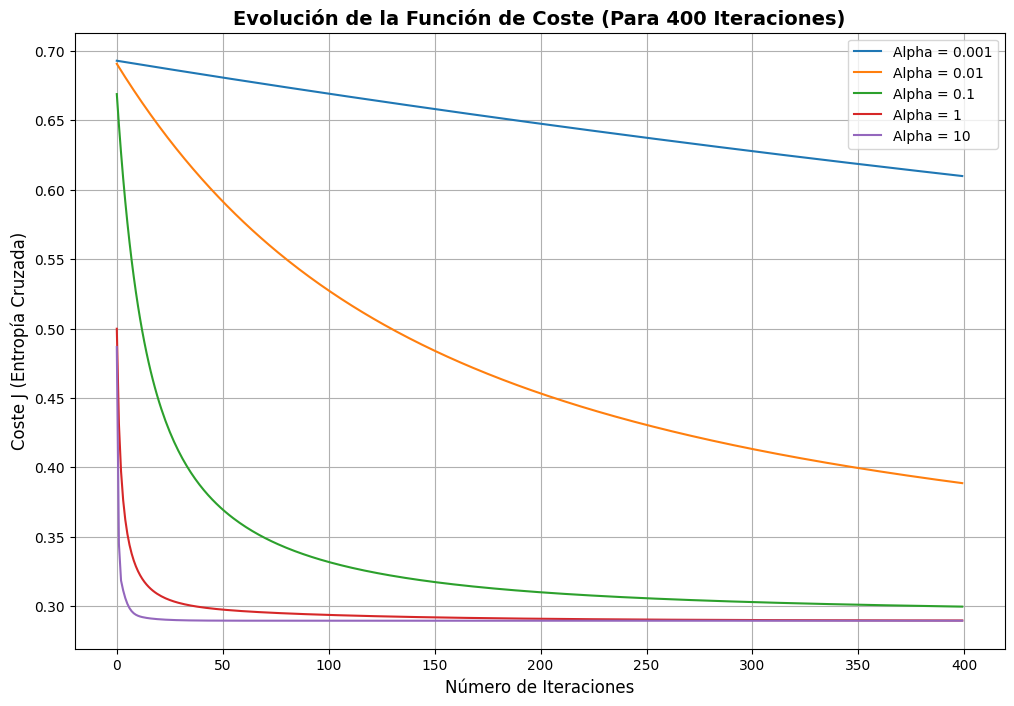

In [19]:
# --- Grafica de convergencia para distintos alphas (100 iteraciones) ---
plt.figure(figsize=(12, 8))
alphas = [0.001, 0.01, 0.1, 1, 10, 100]  # Distintos valores de alpha

for alpha in alphas:
    # Reiniciamos theta para cada alpha
    theta_ini = np.zeros(X.shape[1])
    
    # Ejecutamos descenso de gradiente
    theta_opt, J_history = gradientDescent(X, y_vec, theta_ini, alpha, 50)
    
    # Dibujamos la convergencia
    plt.plot(range(len(J_history)), J_history, label=f'Alpha = {alpha}')

plt.title('Evolución de la Función de Coste (Para 50 Iteraciones)', fontsize=14, fontweight='bold')
plt.xlabel('Número de Iteraciones', fontsize=12)
plt.ylabel('Coste J (Entropía Cruzada)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#--- Grafica de convergencia para distintos alphas (400 iteraciones) ---
plt.figure(figsize=(12, 8))

for alpha in alphas:
    # Reiniciamos theta para cada alpha
    theta_ini = np.zeros(X.shape[1])
    
    # Ejecutamos descenso de gradiente
    theta_opt, J_history = gradientDescent(X, y_vec, theta_ini, alpha, 400)
    
    # Dibujamos la convergencia
    plt.plot(range(len(J_history)), J_history, label=f'Alpha = {alpha}')

plt.title('Evolución de la Función de Coste (Para 400 Iteraciones)', fontsize=14, fontweight='bold')
plt.xlabel('Número de Iteraciones', fontsize=12)
plt.ylabel('Coste J (Entropía Cruzada)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#--- Grafica de convergencia para distintos alphas (400 iteraciones) sin tener en cuanta alpha = 100 ---
plt.figure(figsize=(12, 8))

for alpha in alphas[:-1]:
    # Reiniciamos theta para cada alpha
    theta_ini = np.zeros(X.shape[1])
    
    # Ejecutamos descenso de gradiente
    theta_opt, J_history = gradientDescent(X, y_vec, theta_ini, alpha, 400)
    
    # Dibujamos la convergencia
    plt.plot(range(len(J_history)), J_history, label=f'Alpha = {alpha}')

plt.title('Evolución de la Función de Coste (Para 400 Iteraciones)', fontsize=14, fontweight='bold')
plt.xlabel('Número de Iteraciones', fontsize=12)
plt.ylabel('Coste J (Entropía Cruzada)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Impacto de Alpha:**
Teniendo en cuenta que los datos han sido normalizados previamente, se observa el siguiente comportamiento para distintos valores de alpha:

1. **Alpha muy pequeño** (ej: 0.001): 
   - Los pasos son minúsculos
   - Convergencia MUY LENTA
   - Se requieren muchas iteraciones
   - Pero garantiza estabilidad

2. **Alpha óptimo** (ej: 0.1 - 10):
   - Convergencia rápida y estable
   - Encuentra el mínimo en pocas iteraciones
   - Depende de la escala de los datos

3. **Alpha muy grande** (ej: 100):
   - Los pasos son demasiado grandes
   - **DIVERGENCIA**: nos alejamos del mínimo
   - La función de coste crece en lugar de decrecer
   - El algoritmo falla



### 10.3 Analisis en detalle de la Tasa de Aprendizaje (Alpha)
El objetivo de este analisis es comparar escenarios donde **Alpha tiene un buen comportamiento** debido a la **calidad de los datos de entrada**. Y tambien, escenarios donde **aun teniendo calidad en los datos de entrada**, podemos ver como **valores muy grandes de Alpha** llevan a que el **la funcion de coste no converja**. 

In [20]:
# --- ANÁLISIS DETALLADO: Alpha = 10 con 15 iteraciones X Normalizada---
print("\n" + "="*80)
print("ANÁLISIS DETALLADO: CONVERGENCIA CON ALPHA = 10 y X NORMALIZADA")
print("="*80)

theta_ini = np.zeros(X.shape[1])
theta = theta_ini.copy()
alpha = 10
num_iters_detailed = 15

print(f"\nEjecutando descenso de gradiente con ALPHA = {alpha} durante {num_iters_detailed} iteraciones:\n")
print(f"{'Iteración':<12} {'Coste J':<20} {'Cambio en J':<20}")
print("-" * 52)

J_history_alpha10 = []
coste_anterior = costFunction(theta, X, y_vec)
J_history_alpha10.append(coste_anterior)

print(f"{'0':<12} {coste_anterior:<20.6e} {'INICIAL':<20}")

for i in range(num_iters_detailed):
    grad = gradientFunction(theta, X, y_vec)
    theta = theta - alpha * grad
    coste_actual = costFunction(theta, X, y_vec)
    J_history_alpha10.append(coste_actual)
    
    cambio = coste_actual - coste_anterior
    cambio_porcentaje = (cambio / coste_anterior) * 100 if coste_anterior != 0 else 0
    
    print(f"{i+1:<12} {coste_actual:<20.6e} {cambio:+.6e} ({cambio_porcentaje:+.2f}%)")
    coste_anterior = coste_actual

# --- ANÁLISIS DETALLADO: Alpha = 10 con 15 iteraciones y X Sin Normalizar---
print("\n" + "="*80)
print("ANÁLISIS DETALLADO: CONVERGENCIA CON ALPHA = 10 y X SIN NORMALIZAR")
print("="*80)

theta_ini = np.zeros(X_full.shape[1])
theta = theta_ini.copy()
alpha = 10
num_iters_detailed = 15

print(f"\nEjecutando descenso de gradiente con ALPHA = {alpha} durante {num_iters_detailed} iteraciones:\n")
print(f"{'Iteración':<12} {'Coste J':<20} {'Cambio en J':<20}")
print("-" * 52)

J_history_alpha10 = []
coste_anterior = costFunction(theta, X_full, y_vec)
J_history_alpha10.append(coste_anterior)

print(f"{'0':<12} {coste_anterior:<20.6e} {'INICIAL':<20}")

for i in range(num_iters_detailed):
    grad = gradientFunction(theta, X_full, y_vec)
    theta = theta - alpha * grad
    coste_actual = costFunction(theta, X_full, y_vec)
    J_history_alpha10.append(coste_actual)
    
    cambio = coste_actual - coste_anterior
    cambio_porcentaje = (cambio / coste_anterior) * 100 if coste_anterior != 0 else 0
    
    print(f"{i+1:<12} {coste_actual:<20.6e} {cambio:+.6e} ({cambio_porcentaje:+.2f}%)")
    coste_anterior = coste_actual

# --- ANÁLISIS DETALLADO: Alpha = 100 con 15 iteraciones con X Normalizada---
print("\n" + "="*80)
print("ANÁLISIS DETALLADO: DIVERGENCIA CON ALPHA = 100 y X NORMALIZADA")
print("="*80)

theta_ini = np.zeros(X.shape[1])
theta = theta_ini.copy()
alpha = 100
num_iters_detailed = 15

print(f"\nEjecutando descenso de gradiente con ALPHA = {alpha} durante {num_iters_detailed} iteraciones:\n")
print(f"{'Iteración':<12} {'Coste J':<20} {'Cambio en J':<20}")
print("-" * 52)

J_history_alpha100 = []
coste_anterior = costFunction(theta, X, y_vec)
J_history_alpha100.append(coste_anterior)

print(f"{'0':<12} {coste_anterior:<20.6e} {'INICIAL':<20}")

for i in range(num_iters_detailed):
    grad = gradientFunction(theta, X, y_vec)
    theta = theta - alpha * grad
    coste_actual = costFunction(theta, X, y_vec)
    J_history_alpha100.append(coste_actual)
    
    cambio = coste_actual - coste_anterior
    cambio_porcentaje = (cambio / coste_anterior) * 100 if coste_anterior != 0 else 0
    
    print(f"{i+1:<12} {coste_actual:<20.6e} {cambio:+.6e} ({cambio_porcentaje:+.2f}%)")
    coste_anterior = coste_actual



ANÁLISIS DETALLADO: CONVERGENCIA CON ALPHA = 10 y X NORMALIZADA

Ejecutando descenso de gradiente con ALPHA = 10 durante 15 iteraciones:

Iteración    Coste J              Cambio en J         
----------------------------------------------------
0            6.931472e-01         INICIAL             
1            4.866916e-01         -2.064556e-01 (-29.79%)
2            3.448587e-01         -1.418329e-01 (-29.14%)
3            3.184413e-01         -2.641739e-02 (-7.66%)
4            3.113511e-01         -7.090262e-03 (-2.23%)
5            3.058311e-01         -5.519957e-03 (-1.77%)
6            3.016368e-01         -4.194341e-03 (-1.37%)
7            2.985612e-01         -3.075581e-03 (-1.02%)
8            2.963763e-01         -2.184909e-03 (-0.73%)
9            2.948565e-01         -1.519796e-03 (-0.51%)
10           2.938045e-01         -1.051972e-03 (-0.36%)
11           2.930657e-01         -7.387986e-04 (-0.25%)
12           2.925297e-01         -5.360075e-04 (-0.18%)
13          

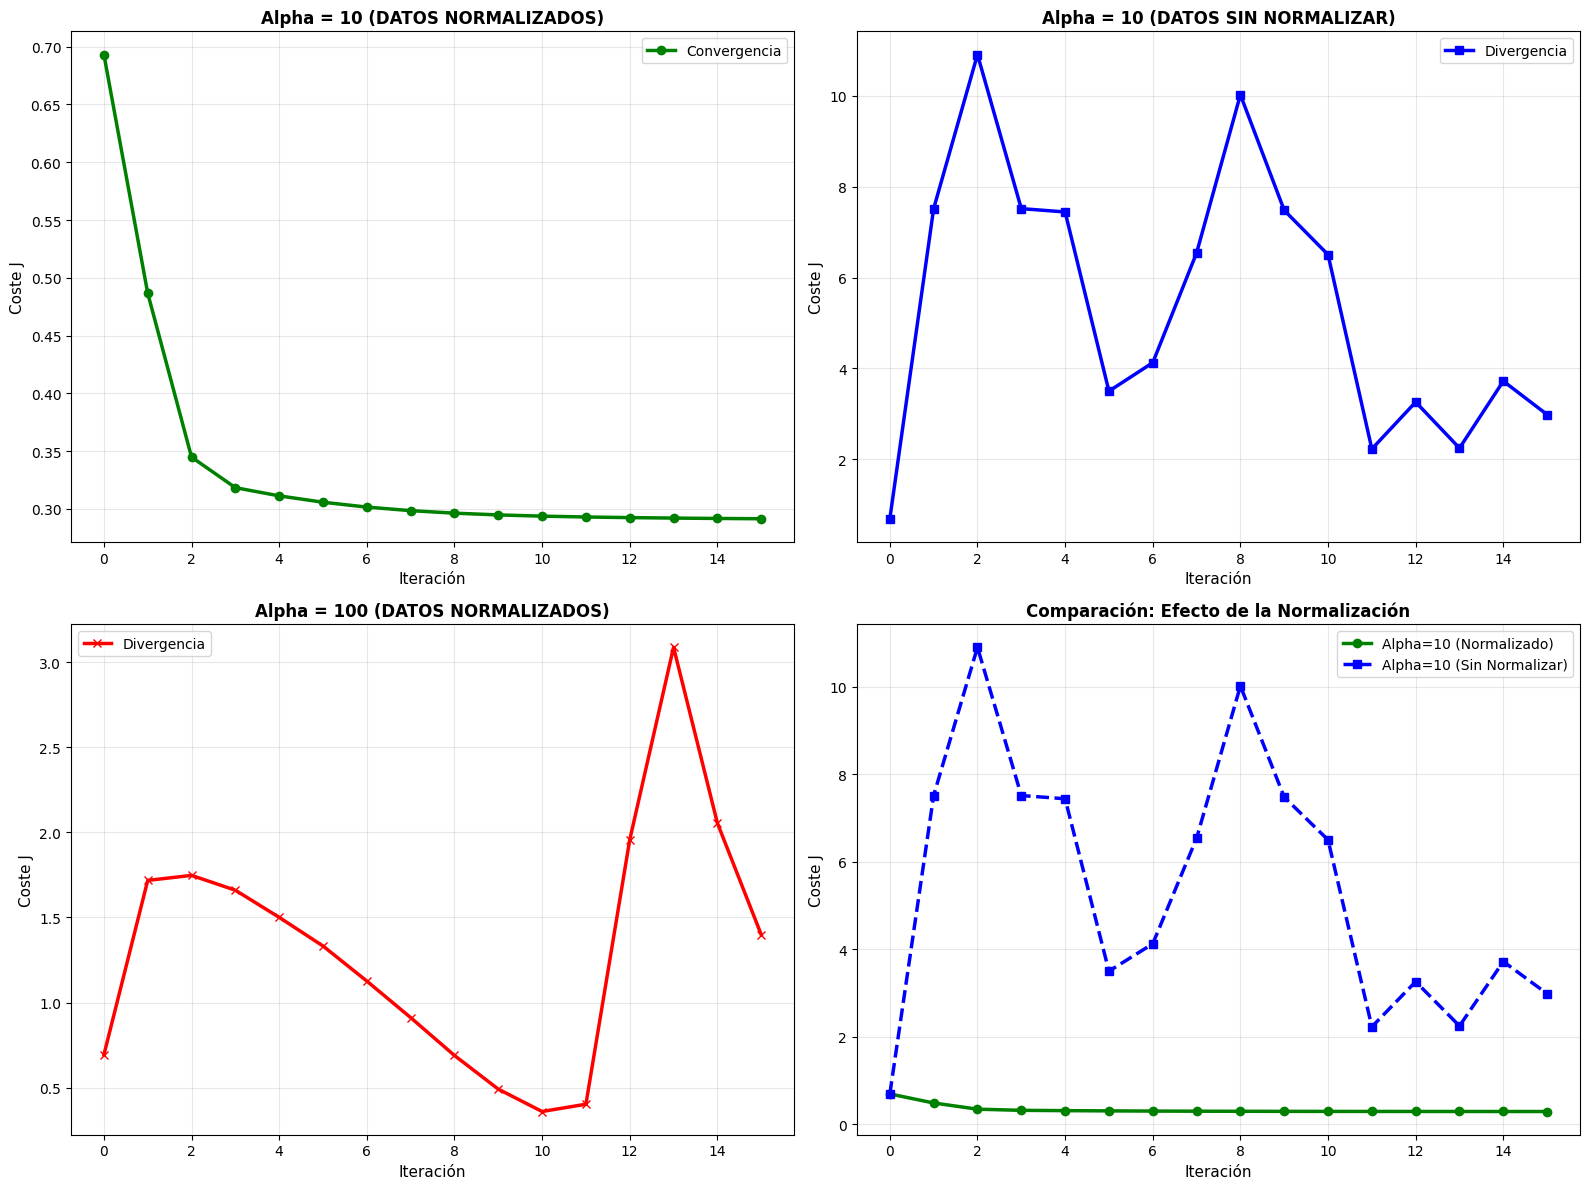


RESUMEN CUANTITATIVO DE LOS 3 ESCENARIOS

1. Alpha = 10 (DATOS NORMALIZADOS):
   Coste inicial: 6.931472e-01
   Coste final:   2.915358e-01
   Cambio total:  -57.94%
   Estado:        CONVERGENCIA

2. Alpha = 10 (DATOS SIN NORMALIZAR):
   Coste inicial: 6.931472e-01
   Coste final:   2.984150e+00
   Cambio total:  330.52%
   Estado:        DIVERGENCIA

3. Alpha = 100 (DATOS NORMALIZADOS):
   Coste inicial: 6.931472e-01
   Coste final:   1.399341e+00
   Cambio total:  101.88%
   Estado:        DIVERGENCIA



In [21]:

# --- Gráficas de convergencia para diferentes escenarios ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Alpha = 10 CON DATOS NORMALIZADOS
theta_ini = np.zeros(X.shape[1])
theta = theta_ini.copy()
alpha = 10
J_history_alpha10_norm = [costFunction(theta, X, y_vec)]

for i in range(15):
    grad = gradientFunction(theta, X, y_vec)
    theta = theta - alpha * grad
    J_history_alpha10_norm.append(costFunction(theta, X, y_vec))

axes[0, 0].plot(range(len(J_history_alpha10_norm)), J_history_alpha10_norm, 'g-', linewidth=2.5, marker='o', markersize=6)
axes[0, 0].set_title('Alpha = 10 (DATOS NORMALIZADOS)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Iteración', fontsize=11)
axes[0, 0].set_ylabel('Coste J', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(['Convergencia'], fontsize=10, loc='upper right')

# 2. Alpha = 10 CON DATOS SIN NORMALIZAR
theta_ini = np.zeros(X_full.shape[1])
theta = theta_ini.copy()
alpha = 10
J_history_alpha10_sin_norm = [costFunction(theta, X_full, y_vec)]

for i in range(15):
    grad = gradientFunction(theta, X_full, y_vec)
    theta = theta - alpha * grad
    J_history_alpha10_sin_norm.append(costFunction(theta, X_full, y_vec))

axes[0, 1].plot(range(len(J_history_alpha10_sin_norm)), J_history_alpha10_sin_norm, 'b-', linewidth=2.5, marker='s', markersize=6)
axes[0, 1].set_title('Alpha = 10 (DATOS SIN NORMALIZAR)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Iteración', fontsize=11)
axes[0, 1].set_ylabel('Coste J', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(['Divergencia'], fontsize=10, loc='upper right')

# 3. Alpha = 100 CON DATOS NORMALIZADOS
theta_ini = np.zeros(X.shape[1])
theta = theta_ini.copy()
alpha = 100
J_history_alpha100_norm = [costFunction(theta, X, y_vec)]

for i in range(15):
    grad = gradientFunction(theta, X, y_vec)
    theta = theta - alpha * grad
    J_history_alpha100_norm.append(costFunction(theta, X, y_vec))

axes[1, 0].plot(range(len(J_history_alpha100_norm)), J_history_alpha100_norm, 'r-', linewidth=2.5, marker='x', markersize=6)
axes[1, 0].set_title('Alpha = 100 (DATOS NORMALIZADOS)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Iteración', fontsize=11)
axes[1, 0].set_ylabel('Coste J', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(['Divergencia'], fontsize=10, loc='upper left')

# 4. COMPARACIÓN: Alpha = 10 (Normalizado vs Sin Normalizar)
axes[1, 1].plot(range(len(J_history_alpha10_norm)), J_history_alpha10_norm, 'g-', linewidth=2.5, marker='o', markersize=6, label='Alpha=10 (Normalizado)')
axes[1, 1].plot(range(len(J_history_alpha10_sin_norm)), J_history_alpha10_sin_norm, 'b--', linewidth=2.5, marker='s', markersize=6, label='Alpha=10 (Sin Normalizar)')
axes[1, 1].set_title('Comparación: Efecto de la Normalización', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Iteración', fontsize=11)
axes[1, 1].set_ylabel('Coste J', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("RESUMEN CUANTITATIVO DE LOS 3 ESCENARIOS")
print("="*80)
print(f"\n1. Alpha = 10 (DATOS NORMALIZADOS):")
print(f"   Coste inicial: {J_history_alpha10_norm[0]:.6e}")
print(f"   Coste final:   {J_history_alpha10_norm[-1]:.6e}")
print(f"   Cambio total:  {((J_history_alpha10_norm[-1] - J_history_alpha10_norm[0]) / J_history_alpha10_norm[0] * 100):.2f}%")
print(f"   Estado:        CONVERGENCIA")

print(f"\n2. Alpha = 10 (DATOS SIN NORMALIZAR):")
print(f"   Coste inicial: {J_history_alpha10_sin_norm[0]:.6e}")
print(f"   Coste final:   {J_history_alpha10_sin_norm[-1]:.6e}")
cambio_sin_norm = ((J_history_alpha10_sin_norm[-1] - J_history_alpha10_sin_norm[0]) / J_history_alpha10_sin_norm[0] * 100)
print(f"   Cambio total:  {cambio_sin_norm:.2f}%")
estado_sin_norm = "DIVERGENCIA" if cambio_sin_norm > 0 else "CONVERGENCIA"
print(f"   Estado:        {estado_sin_norm}")

print(f"\n3. Alpha = 100 (DATOS NORMALIZADOS):")
print(f"   Coste inicial: {J_history_alpha100_norm[0]:.6e}")
print(f"   Coste final:   {J_history_alpha100_norm[-1]:.6e}")
cambio_100 = ((J_history_alpha100_norm[-1] - J_history_alpha100_norm[0]) / J_history_alpha100_norm[0] * 100)
print(f"   Cambio total:  {cambio_100:.2f}%")
print(f"   Estado:        DIVERGENCIA")

print("="*80 + "\n")


### CONCLUSIÓN DE COMPARACIÓN

La normalización es CRÍTICA: 
- Alpha=10 diverge sin ella, pero converge con ella. 
- Esto demuestra la importancia de normalizar antes de aplicar descenso de gradiente.